# Sketch Recognition using Simple Neural Network (NN)

In [325]:
# Selecting Tensorflow version v2 (the command is relevant for Colab only).
# %tensorflow_version 2.x

In [326]:
import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
import numpy as np
import math
import datetime
import platform
import pathlib

print('Python version:', platform.python_version())
print('Tensorflow version:', tf.__version__)
print('Keras version:', tf.keras.__version__)

Python version: 3.7.6
Tensorflow version: 2.1.0
Keras version: 2.2.4-tf


In [327]:
cache_dir = 'tmp';

In [328]:
# Create cache folder.
!mkdir tmp

mkdir: tmp: File exists


## Loading dataset

In [13]:
# List all available datasets to see how the wikipedia dataset is called.
tfds.list_builders()

['abstract_reasoning',
 'aeslc',
 'aflw2k3d',
 'amazon_us_reviews',
 'arc',
 'bair_robot_pushing_small',
 'big_patent',
 'bigearthnet',
 'billsum',
 'binarized_mnist',
 'binary_alpha_digits',
 'c4',
 'caltech101',
 'caltech_birds2010',
 'caltech_birds2011',
 'cars196',
 'cassava',
 'cats_vs_dogs',
 'celeb_a',
 'celeb_a_hq',
 'chexpert',
 'cifar10',
 'cifar100',
 'cifar10_1',
 'cifar10_corrupted',
 'citrus_leaves',
 'cityscapes',
 'civil_comments',
 'clevr',
 'cmaterdb',
 'cnn_dailymail',
 'coco',
 'coil100',
 'colorectal_histology',
 'colorectal_histology_large',
 'cos_e',
 'curated_breast_imaging_ddsm',
 'cycle_gan',
 'deep_weeds',
 'definite_pronoun_resolution',
 'diabetic_retinopathy_detection',
 'dmlab',
 'downsampled_imagenet',
 'dsprites',
 'dtd',
 'duke_ultrasound',
 'dummy_dataset_shared_generator',
 'dummy_mnist',
 'emnist',
 'esnli',
 'eurosat',
 'fashion_mnist',
 'flic',
 'flores',
 'food101',
 'gap',
 'gigaword',
 'glue',
 'groove',
 'higgs',
 'horses_or_humans',
 'i_natura

In [41]:
DATASET_NAME = 'quickdraw_bitmap'

dataset, dataset_info = tfds.load(
    name=DATASET_NAME,
    data_dir=cache_dir,
    with_info=True,
    split=tfds.Split.TRAIN,
)

In [42]:
print(dataset_info)

tfds.core.DatasetInfo(
    name='quickdraw_bitmap',
    version=3.0.0,
    description='The Quick Draw Dataset is a collection of 50 million drawings across 345 categories, contributed by players of the game Quick, Draw!. The bitmap dataset contains these drawings converted from vector format into 28x28 grayscale images',
    homepage='https://github.com/googlecreativelab/quickdraw-dataset',
    features=FeaturesDict({
        'image': Image(shape=(28, 28, 1), dtype=tf.uint8),
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=345),
    }),
    total_num_examples=50426266,
    splits={
        'train': 50426266,
    },
    supervised_keys=('image', 'label'),
    citation="""@article{DBLP:journals/corr/HaE17,
      author    = {David Ha and
                   Douglas Eck},
      title     = {A Neural Representation of Sketch Drawings},
      journal   = {CoRR},
      volume    = {abs/1704.03477},
      year      = {2017},
      url       = {http://arxiv.org/abs/1704.03477

In [43]:
image_shape = dataset_info.features['image'].shape
num_classes = dataset_info.features['label'].num_classes
num_examples = dataset_info.splits['train'].num_examples

print('num_examples: ', num_examples)
print('image_shape: ', image_shape)
print('num_classes: ', num_classes)

num_examples:  50426266
image_shape:  (28, 28, 1)
num_classes:  345


In [88]:
label_index_to_string = dataset_info.features['label'].int2str

classes = []

for class_index in range(num_classes):
    classes.append(label_index_to_string(class_index))
    
print(classes)

['aircraft carrier', 'airplane', 'alarm clock', 'ambulance', 'angel', 'animal migration', 'ant', 'anvil', 'apple', 'arm', 'asparagus', 'axe', 'backpack', 'banana', 'bandage', 'barn', 'baseball bat', 'baseball', 'basket', 'basketball', 'bat', 'bathtub', 'beach', 'bear', 'beard', 'bed', 'bee', 'belt', 'bench', 'bicycle', 'binoculars', 'bird', 'birthday cake', 'blackberry', 'blueberry', 'book', 'boomerang', 'bottlecap', 'bowtie', 'bracelet', 'brain', 'bread', 'bridge', 'broccoli', 'broom', 'bucket', 'bulldozer', 'bus', 'bush', 'butterfly', 'cactus', 'cake', 'calculator', 'calendar', 'camel', 'camera', 'camouflage', 'campfire', 'candle', 'cannon', 'canoe', 'car', 'carrot', 'castle', 'cat', 'ceiling fan', 'cell phone', 'cello', 'chair', 'chandelier', 'church', 'circle', 'clarinet', 'clock', 'cloud', 'coffee cup', 'compass', 'computer', 'cookie', 'cooler', 'couch', 'cow', 'crab', 'crayon', 'crocodile', 'crown', 'cruise ship', 'cup', 'diamond', 'dishwasher', 'diving board', 'dog', 'dolphin', 

In [44]:
print(dataset)

<DatasetV1Adapter shapes: {image: (28, 28, 1), label: ()}, types: {image: tf.uint8, label: tf.int64}>


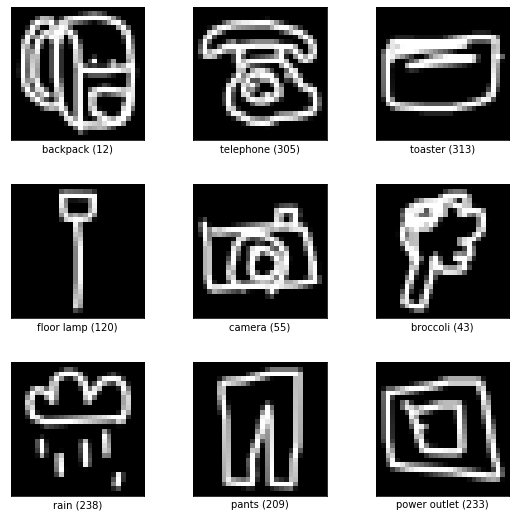

In [137]:
fig = tfds.show_examples(dataset_info, dataset)

In [104]:
def dataset_preview(dataset, image_shape, preview_images_num=25):
    num_cells = math.ceil(math.sqrt(preview_images_num))
    plt.figure(figsize=(10, 10))
    image_size = image_shape[0]
    
    for image_index, example in enumerate(dataset.take(preview_images_num)):
        image = example['image']
        label = example['label']
        
        class_index = label.numpy()
        class_name = label_index_to_string(class_index)
        
        plt.subplot(num_cells, num_cells, image_index + 1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        plt.imshow(
            np.reshape(image, (image_size, image_size)),
            cmap=plt.cm.binary
        )
        plt.xlabel('{} ({})'.format(class_name, class_index))
    plt.show()

In [133]:
def dataset_head(ds):
    for example in ds.take(1):
        image = example['image']
        label = example['label']

        class_index = label.numpy()
        class_name = label_index_to_string(class_index)

        print('{} ({})'.format(class_name, class_index), '\n')
        print('Image shape: ', image.shape, '\n')
        print(image.numpy(), '\n')

In [134]:
dataset_head(dataset)

backpack (12) 

Image shape:  (28, 28, 1) 

[[[  0]
  [  0]
  [  0]
  [  0]
  [  0]
  [  0]
  [  0]
  [  0]
  [  0]
  [  0]
  [  0]
  [  0]
  [  0]
  [  0]
  [  0]
  [  0]
  [  0]
  [  0]
  [  0]
  [  0]
  [  0]
  [  0]
  [  0]
  [  0]
  [  0]
  [  0]
  [  0]
  [  0]]

 [[  0]
  [  0]
  [  0]
  [  0]
  [  0]
  [  0]
  [  0]
  [  0]
  [  0]
  [  0]
  [  0]
  [  0]
  [  0]
  [  3]
  [ 31]
  [ 63]
  [ 95]
  [115]
  [ 86]
  [ 50]
  [  2]
  [  0]
  [  0]
  [  0]
  [  0]
  [  0]
  [  0]
  [  0]]

 [[  0]
  [  0]
  [  0]
  [  0]
  [  0]
  [ 75]
  [183]
  [176]
  [152]
  [ 10]
  [ 54]
  [182]
  [222]
  [250]
  [255]
  [255]
  [255]
  [255]
  [255]
  [255]
  [231]
  [151]
  [ 61]
  [  0]
  [  0]
  [  0]
  [  0]
  [  0]]

 [[  0]
  [  0]
  [  0]
  [  0]
  [129]
  [255]
  [216]
  [202]
  [255]
  [ 98]
  [220]
  [222]
  [157]
  [125]
  [ 93]
  [ 60]
  [ 28]
  [  8]
  [ 38]
  [ 82]
  [162]
  [239]
  [254]
  [108]
  [  0]
  [  0]
  [  0]
  [  0]]

 [[  0]
  [  0]
  [  0]
  [ 33]
  [250]
  [158]
  [ 

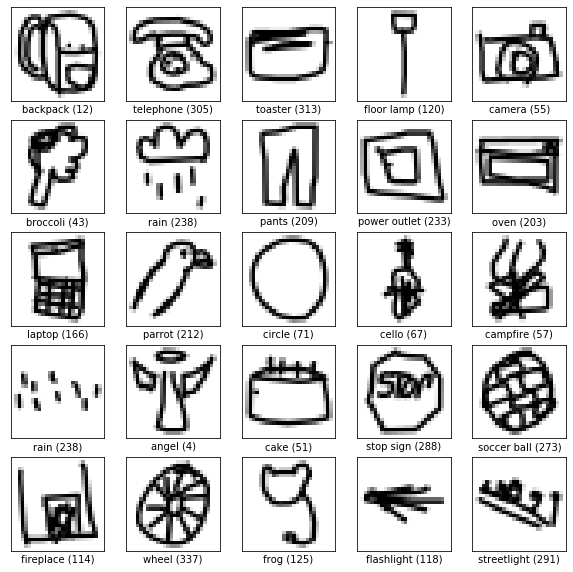

In [105]:
dataset_preview(dataset, image_shape)

In [188]:
def normalize_example(example):
    image = example['image']
    label = example['label']
    
    image = tf.math.divide(image, 255)
    
    return (image, label)

In [189]:
dataset_normalized = dataset.map(normalize_example)

In [190]:
for (image, label) in dataset_normalized.take(1):
    class_index = label.numpy()
    class_name = label_index_to_string(class_index)

    print('{} ({})'.format(class_name, class_index), '\n')
    print('Image shape: ', image.shape, '\n')
    print(image.numpy(), '\n')

backpack (12) 

Image shape:  (28, 28, 1) 

[[[0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]]

 [[0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.01176471]
  [0.12156863]
  [0.24705882]
  [0.37254903]
  [0.4509804 ]
  [0.3372549 ]
  [0.19607843]
  [0.00784314]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]]

 [[0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.        ]
  [0.29411766]
  [0.7176471 ]
  [0.69

In [308]:
# Dataset split
test_dataset_size = 100 # Number of batches
validation_dataset_size = 10 # Number of batches

# Dataset batching and shuffling
shuffle_buffer_size = 1000
batch_size = 1000
prefetch_buffer_size = 10

# Training
epochs = 10
steps_per_epoch = 10

In [309]:
dataset_shuffled = dataset_normalized.shuffle(
    buffer_size=shuffle_buffer_size,
    reshuffle_each_iteration=False
)

In [310]:
# A quick example of how we're going to split the dataset for train/test/validation subsets.
tmp_ds = tf.data.Dataset.range(10)
print('tmp_ds:', list(tmp_ds.as_numpy_iterator()))

tmp_ds_test = tmp_ds.take(2)
print('tmp_ds_test:', list(tmp_ds_test.as_numpy_iterator()))

tmp_ds_val = tmp_ds.skip(2).take(3)
print('tmp_ds_val:', list(tmp_ds_val.as_numpy_iterator()))

tmp_ds_train = tmp_ds.skip(2 + 3)
print('tmp_ds_train:', list(tmp_ds_train.as_numpy_iterator()))

tmp_ds: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
tmp_ds_test: [0, 1]
tmp_ds_val: [2, 3, 4]
tmp_ds_train: [5, 6, 7, 8, 9]


In [311]:
# TEST
dataset_test = dataset_shuffled \
    .take(test_dataset_size)\
    .batch(batch_size=batch_size) \
    .prefetch(buffer_size=prefetch_buffer_size)

# VALIDATION
dataset_val = dataset_shuffled \
    .skip(test_dataset_size) \
    .take(validation_dataset_size)\
    .batch(batch_size=batch_size) \
    .prefetch(buffer_size=prefetch_buffer_size)

# TRAIN
dataset_train = dataset_shuffled \
    .skip(test_dataset_size + validation_dataset_size) \
    .batch(batch_size=batch_size) \
    .prefetch(buffer_size=prefetch_buffer_size)

In [312]:
for (image_test, label_test) in dataset_test.take(1):
    print('label_test.shape: ', label_test.shape)
    print('image_test.shape: ', image_test.shape)
    
print()    
    
for (image_val, label_val) in dataset_val.take(1):
    print('label_val.shape: ', label_val.shape)
    print('image_val.shape: ', image_val.shape)    
    
print()    
    
for (image_train, label_train) in dataset_train.take(1):
    print('label_train.shape: ', label_train.shape)
    print('image_train.shape: ', image_train.shape)    

label_test.shape:  (100,)
image_test.shape:  (100, 28, 28, 1)

label_val.shape:  (10,)
image_val.shape:  (10, 28, 28, 1)

label_train.shape:  (1000,)
image_train.shape:  (1000, 28, 28, 1)


In [313]:
model = tf.keras.models.Sequential()

model.add(tf.keras.layers.Flatten(
    input_shape=image_shape
))

model.add(tf.keras.layers.Dense(
    units=512,
    activation=tf.keras.activations.relu
))

model.add(tf.keras.layers.Dense(
    units=256,
    activation=tf.keras.activations.relu
))

model.add(tf.keras.layers.Dense(
    units=num_classes,
    activation=tf.keras.activations.softmax
))

In [314]:
model.summary()

Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_11 (Flatten)         (None, 784)               0         
_________________________________________________________________
dense_29 (Dense)             (None, 512)               401920    
_________________________________________________________________
dense_30 (Dense)             (None, 256)               131328    
_________________________________________________________________
dense_31 (Dense)             (None, 345)               88665     
Total params: 621,913
Trainable params: 621,913
Non-trainable params: 0
_________________________________________________________________


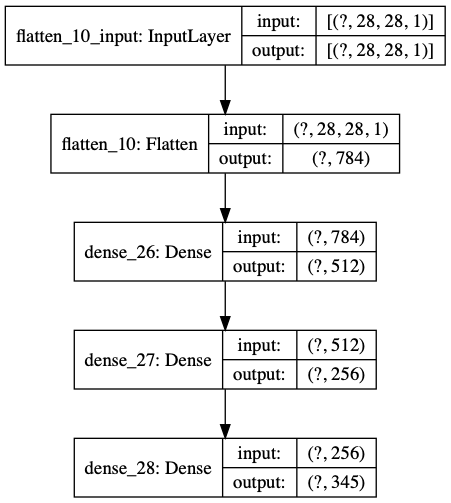

In [303]:
tf.keras.utils.plot_model(
    model,
    show_shapes=True,
    show_layer_names=True,
)

In [315]:
adam_optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

model.compile(
    optimizer=adam_optimizer,
    loss=tf.keras.losses.sparse_categorical_crossentropy,
    metrics=['accuracy']
)

In [316]:
training_history = model.fit(
    x=dataset_train,
    epochs=epochs,
    steps_per_epoch=steps_per_epoch,
    validation_data=dataset_val
)

Train for 10 steps
Epoch 1/10
10/10 [==============================] - 4s 444ms/step - loss: 5.7867 - accuracy: 0.0116 - val_loss: 5.7405 - val_accuracy: 0.0000e+00
Epoch 2/10
10/10 [==============================] - 2s 197ms/step - loss: 5.5695 - accuracy: 0.0280 - val_loss: 5.6764 - val_accuracy: 0.0000e+00
Epoch 3/10
10/10 [==============================] - 2s 186ms/step - loss: 5.2515 - accuracy: 0.0457 - val_loss: 5.5383 - val_accuracy: 0.0000e+00
Epoch 4/10
10/10 [==============================] - 2s 180ms/step - loss: 4.9528 - accuracy: 0.0787 - val_loss: 5.3920 - val_accuracy: 0.2000
Epoch 5/10
10/10 [==============================] - 2s 215ms/step - loss: 4.7392 - accuracy: 0.0955 - val_loss: 5.3807 - val_accuracy: 0.0000e+00
Epoch 6/10
10/10 [==============================] - 2s 201ms/step - loss: 4.5993 - accuracy: 0.1173 - val_loss: 4.9433 - val_accuracy: 0.1000
Epoch 7/10
10/10 [==============================] - 2s 187ms/step - loss: 4.4226 - accuracy: 0.1399 - val_loss: 4

In [317]:
# Renders the charts for training accuracy and loss.
def render_training_history(training_history):
    loss = training_history.history['loss']
    val_loss = training_history.history['val_loss']

    accuracy = training_history.history['accuracy']
    val_accuracy = training_history.history['val_accuracy']

    plt.figure(figsize=(14, 4))

    plt.subplot(1, 2, 1)
    plt.title('Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.plot(loss, label='Training set')
    plt.plot(val_loss, label='Test set', linestyle='--')
    plt.legend()
    plt.grid(linestyle='--', linewidth=1, alpha=0.5)

    plt.subplot(1, 2, 2)
    plt.title('Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.plot(accuracy, label='Training set')
    plt.plot(val_accuracy, label='Test set', linestyle='--')
    plt.legend()
    plt.grid(linestyle='--', linewidth=1, alpha=0.5)

    plt.show()

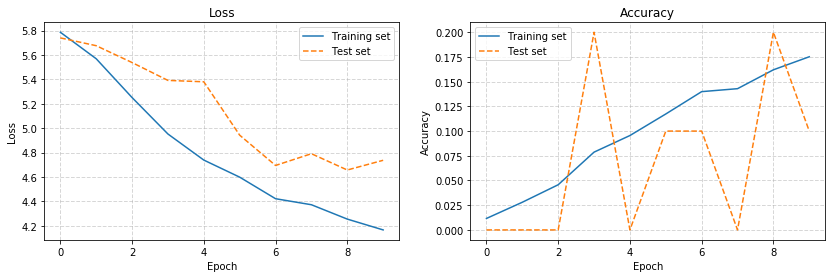

In [318]:
render_training_history(training_history)

## Evaluate model accuracy

### Training set accuracy

In [334]:
%%capture
train_loss, train_accuracy = model.evaluate(dataset_train.take(100))

In [335]:
print('Train loss: ', '{:.2f}'.format(train_loss))
print('Train accuracy: ', '{:.2f}'.format(train_accuracy))

Train loss:  4.05
Train accuracy:  0.19


### Validation set accuracy

In [336]:
%%capture
val_loss, val_accuracy = model.evaluate(dataset_val)

In [337]:
print('Validation loss: ', '{:.2f}'.format(val_loss))
print('Validation accuracy: ', '{:.2f}'.format(val_accuracy))

Validation loss:  4.74
Validation accuracy:  0.10


### Test set accuracy

In [338]:
%%capture
test_loss, test_accuracy = model.evaluate(dataset_test)

In [339]:
print('Test loss: ', '{:.2f}'.format(test_loss))
print('Test accuracy: ', '{:.2f}'.format(test_accuracy))

Test loss:  3.91
Test accuracy:  0.24


## Save the model

We will save the entire model to a `HDF5` file. The `.h5` extension of the file indicates that the model should be saved in Keras format as HDF5 file. To use this model on the front-end we will convert it (later in this notebook) to Javascript understandable format (`tfjs_layers_model` with .json and .bin files) using [tensorflowjs_converter](https://www.tensorflow.org/js/tutorials/conversion/import_saved_model) as it is specified in the [main README](https://github.com/trekhleb/machine-learning-experiments).

In [340]:
model_name = 'sketch_recognition_mlp.h5'
model.save(model_name, save_format='h5')

## Converting the model to web-format

To use this model on the web we need to convert it into the format that will be understandable by [tensorflowjs](https://www.tensorflow.org/js). To do so we may use [tfjs-converter](https://github.com/tensorflow/tfjs/tree/master/tfjs-converter) as following:

```
tensorflowjs_converter --input_format keras \
  ./experiments/sketch_recognition_mlp/sketch_recognition_mlp.h5 \
  ./demos/public/models/sketch_recognition_mlp
```

You find this experiment in the [Demo app](https://trekhleb.github.io/machine-learning-experiments) and play around with it right in you browser to see how the model performs in real life.